## Assignment 01

In [21]:
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display,Image
from sklearn.linear_model import LogisticRegression
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#这个程序用来下载文件
url = 'https://commondatastorage.googleapis.com/books1000/'
last_parcent_reported = None
data_root = '.'
def download_progress_hook(count,blockSize,totalSize):  #显示下载进度
    global last_percent_reported
    percent = int(count*blockSize*100/totalSize)
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
        last_percent_reported = percent
def maybe_download(filename,expected_bytes,force = False):
    dest_filename = os.path.join(data_root,filename)   #存储路径
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:',filename)
        filename,_ = urlretrieve(url+filename,dest_filename,reporthook = download_progress_hook)  #下载函数
        print('\nDownload complete')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified',dest_filename)
    else:
        raise Exception('Failed to verify'+dest_filename+'. Can you get to it with a brower')
    return dest_filename
train_filename = maybe_download('notMNIST_large.tar.gz',247336696)
test_filename = maybe_download('notMNIST_small.tar.gz',8458043)

        

In [ ]:
def cbk(a,b,c):
    per = a*b*100/c
    if per>100:
        per = 100
    print('%0.2f%%'%per)
url='http://www.python.org/ftp/python/2.7.5/Python-2.7.5.tar.bz2'   
#测试一下，下载数据
dir=os.path.abspath('.')
work_path=os.path.join(dir,'Python-2.7.5.tar.bz2')  #设置保存路径
urlretrieve(url,work_path,cbk)  #下载文件

In [22]:
num_class = 10
np.random.seed(133)

def maybe_extract(filename,force = False):   #解压文件
    root = os.path.splitext(os.path.splitext(filename)[0])[0]
    if os.path.isdir(root) and not force:
        print('%s already present -Skipping extraction of %s.' % (root,filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.'% root) 
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = [os.path.join(root,d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root,d))]
    if len(data_folders) != num_class:
        raise Exception('Excepted %d folders,one per class. Found %d instead.' % (num_classes,len(data_folders)))
    print(data_folders)
    return data_folders

train_folders = maybe_extract('.\\notMNIST_large.tar.gz')
test_folders = maybe_extract('.\\notMNIST_small.tar.gz')

.\notMNIST_large already present -Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present -Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


In [23]:
image_size = 28
pixel_depth = 255.0
#利用pickle分别存储每个类型的数据，然后再分别处理。 之后，汇总到一个可具操作性的数据集中。
def load_letter(folder,min_num_images):
    """load the data for a single letter label"""
    image_files = os.listdir(folder)   #所有文件
    dataset = np.ndarray(shape=(len(image_files),image_size,image_size),dtype=np.float32)
    print(folder)   #打印该文件夹的名字
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder,image)   #对于文件夹里的每张图片
        try:
            image_data = (ndimage.imread(image_file).astype(float)-pixel_depth/2)/pixel_depth
            if image_data.shape != (image_size,image_size):   #如果该图片不是28*28的
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images,:,:] = image_data   #把每张图片的数据写入到dataset中
            num_images = num_images+1
        except IOError as e:
            print('could not read:',image_file,':',e,'- it\'s ok,skipping')
            
    dataset = dataset[0:num_images,:,:]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %(num_images,min_num_images))
    print('Full dataset tensor:',dataset.shape)
    print('Mean:',np.mean(dataset))
    print('Standard deviation:',np.std(dataset))
    return dataset

In [24]:
def maybe_pickle(data_folders,min_num_images_per_class,force = False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder +'.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('pickling %s.' % set_filename)
            dataset = load_letter(folder,min_num_images_per_class)
            try:
                with open(set_filename,'wb') as f:
                    pickle.dump(dataset,f,pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('unable to save data to',set_filename,':',e)
    return dataset_names


In [25]:
train_datasets = maybe_pickle(train_folders,45000)
print(test_folders)
test_datasets = maybe_pickle(test_folders,1800)

.\notMNIST_large\A.pickle already present - Skipping pickling.
.\notMNIST_large\B.pickle already present - Skipping pickling.
.\notMNIST_large\C.pickle already present - Skipping pickling.
.\notMNIST_large\D.pickle already present - Skipping pickling.
.\notMNIST_large\E.pickle already present - Skipping pickling.
.\notMNIST_large\F.pickle already present - Skipping pickling.
.\notMNIST_large\G.pickle already present - Skipping pickling.
.\notMNIST_large\H.pickle already present - Skipping pickling.
.\notMNIST_large\I.pickle already present - Skipping pickling.
.\notMNIST_large\J.pickle already present - Skipping pickling.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']
.\notMNIST_small\A.pickle already present - Skipping pickling.
.\notMNIST_small\B.pickle already present - Skipping pickling.
.\n

## 验证归一化的图像

(52911, 28, 28)


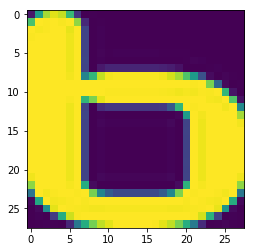

In [7]:
with open('C:/Users/lym/自然语言处理/notMNIST_large/B.pickle','rb') as p:   #打印一个B的图像
    datashow = pickle.load(p)
print(datashow.shape)
pic = datashow[1,:,:]
plt.imshow(pic)
plt.show()

## 验证数据平衡
保证各个数据集的大小相差不大，保证训练的准确性

In [26]:
file_path = 'C:/Users/lym/自然语言处理/notMNIST_large/{0}.pickle'   #看看各个数据集图片张数是不是差不多
for e in 'ABCDEFJHIJ':
    with open(file_path.format(e),'rb') as pk_f:
        data = pickle.load(pk_f)
    print('number of pictures in {}.pickle = '.format(e),data.shape)

number of pictures in A.pickle =  (52909, 28, 28)
number of pictures in B.pickle =  (52911, 28, 28)
number of pictures in C.pickle =  (52912, 28, 28)
number of pictures in D.pickle =  (52911, 28, 28)
number of pictures in E.pickle =  (52912, 28, 28)
number of pictures in F.pickle =  (52912, 28, 28)
number of pictures in J.pickle =  (52911, 28, 28)
number of pictures in H.pickle =  (52912, 28, 28)
number of pictures in I.pickle =  (52912, 28, 28)
number of pictures in J.pickle =  (52911, 28, 28)


## 聚合数据
给数据打标记，创建一个用于参数调整的验证集

In [27]:
def make_arrays(nb_rows,img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows,img_size,img_size),dtype=np.float32)
        labels = np.ndarray(nb_rows,dtype=np.int32)
    else:
        dataset,labels = None,None
    return dataset,labels
def merge_datasets(pickle_files,train_size,valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset,valid_labels = make_arrays(valid_size,image_size)  #(10000,28)
    train_dataset,train_labels = make_arrays(train_size,image_size)   #(200000,28)
    vsize_per_class = valid_size // num_classes  #10000//10
    tsize_per_class = train_size // num_classes   #200000//10
    start_v,start_t = 0,0
    end_v,end_t = vsize_per_class,tsize_per_class   #1000,20000
    end_l = vsize_per_class+tsize_per_class     #1000+20000
    for label,pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file,'rb') as f:
                letter_set = pickle.load(f)   #导入pickle数据集
                np.random.shuffle(letter_set)   #打乱顺序
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class,:,:]
                    valid_dataset[start_v:end_v,:,:] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                train_letter = letter_set[vsize_per_class:end_l,:,:]
                train_dataset[start_t:end_t,:,:] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('unable to process data from',pickle_file,':',e)
            raise
    return valid_dataset,valid_labels,train_dataset,train_labels
#数目可以自行调整           
train_size = 200000
valid_size = 10000
test_size = 10000
 
valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)
 
print('Training:', train_dataset.shape, train_labels.shape)  
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


## 随机化数据

In [28]:
def randomize(dataset,labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset,shuffled_labels
train_dataset,train_labels = randomize(train_dataset,train_labels)
test_dataset,test_labels = randomize(test_dataset,test_labels)
valid_dataset,valid_labels = randomize(valid_dataset,valid_labels)

In [29]:
print(train_dataset.shape)

(200000, 28, 28)


## 验证数据的完好性

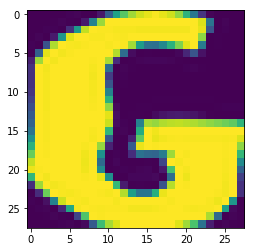

the picture should be  G


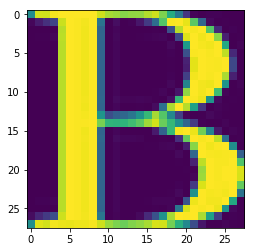

the picture should be  B


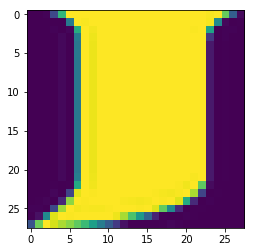

the picture should be  J


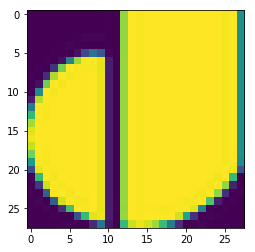

the picture should be  J


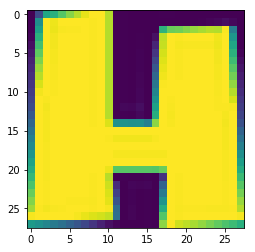

the picture should be  H


In [12]:
mapping = {key:val for key,val in enumerate('ABCDEFGHIJ')}
def plot_check(matrix,key):
    plt.imshow(matrix)
    plt.show()
    print('the picture should be ',mapping[key])
    return None
length = train_dataset.shape[0]-1
for _ in range(5):
    index = np.random.randint(length)
    plot_check(train_dataset[index,:,:],train_labels[index])

### 结果说明图片完好

## 保存数据

In [30]:
pickle_file = os.path.join('C:/Users/lym/自然语言处理/notMNIST.pickle')
try:
    f = open(pickle_file,'wb')
    save = {
        'train_dataset':train_dataset,
        'train_labels':train_labels,
        'valid_dataset':valid_dataset,
        'valid_labels':valid_labels,
        'test_dataset':test_dataset,
        'test_labels':test_labels,
    }
    pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('unable to save data to',pickle_file,':',e)
    raise

In [31]:
stainfo = os.stat(pickle_file)
print('compressed pickle size:',stainfo.st_size)

compressed pickle size: 690800506


## 寻找重叠样本

In [32]:
import multiprocessing as mp
import numpy as np
import pickle as pk
import collections

In [33]:
def check_overlap(dataset1,start,end,dataset2,q):  #寻找重叠样本
    overlappingindex = []
    length1 = dataset1.shape[0]
    for i in range(length1):
        for j in range(start,end):
            error = np.sum(np.sum(np.abs(dataset1[i,:,:]-dataset2[j,:,:])))
            if error < 0.2:
                overlappingindex.append((i,j))
                break
    q.put(tuple(overlappingindex))
    return None

In [18]:
print('start loading notMNIST.pickle')
with open('C:/Users/lym/自然语言处理/notMNIST.pickle','rb') as f:
    data = pk.load(f)
print('loading finished')
q = mp.Queue()
train_dataset = data['train_dataset']
valid_dataset = data['valid_dataset']
length = train_dataset.shape[0]
idx = (0,int(length*1.0/3),int(length*2.0/3),length)
process = []
for i in range(3):
    process.append(mp.Process(target=check_overlap,args = (valid_dataset, idx[i], idx[i+1], train_dataset, q)))
for p in process:
    p.start()
for p in process:
    p.join()
    results = []
    while not q.empty():
        results.append(q.get())
print(results)
func = lambda x:[i for xs in x for i in func(xs)] if isinstance(x,collections.Iterable) else [x]
print(func(results))

start loading notMNIST.pickle
loading finished


BrokenPipeError: [Errno 32] Broken pipe

## 训练简单的机器模型
利用scikit-learn提供的逻辑回归模型，分别将训练集的大小设置为50， 100， 1000， 5000 ，然后查看训练效果：

In [19]:
from sklearn.linear_model import LogisticRegression
import pickle 
import numpy as np
size = 50
image_size =28
# loading data 
print('loading data')
#with open('notMNIST.pickle', 'rb') as f:
#    data  =  pickle.load(f)
print('finish loading')
train_dt = data['train_dataset']
length = train_dt.shape[0]
train_dt = train_dt.reshape(length, image_size*image_size)
train_lb = data['train_labels']
test_dt = data['test_dataset']
length = test_dt.shape[0]
test_lb = data['test_labels']
test_dt = test_dt.reshape(length, image_size*image_size)
def train_linear_logistic(tdata, tlabel):
 
    model = LogisticRegression(C=1.0, penalty='l1')
 
    print('initializing model size is = {}'.format(size))
    model.fit(tdata[:size,:], tlabel[:size])   #训练size以前的数据
 
    print('testing model')
    y_out = model.predict(test_dt)
 
    print('the accurace of the mode of size = {} is {}'.format(size, np.sum(y_out == test_lb)*1.0/len(y_out) ))
 
    return None
 
train_linear_logistic(train_dt, train_lb)
size = 100
train_linear_logistic(train_dt, train_lb)
size = 1000
train_linear_logistic(train_dt, train_lb)
size = 5000
train_linear_logistic(train_dt, train_lb)

loading data
finish loading
initializing model size is = 50


D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


testing model
the accurace of the mode of size = 50 is 0.46
initializing model size is = 100
testing model
the accurace of the mode of size = 100 is 0.6717
initializing model size is = 1000


D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


testing model
the accurace of the mode of size = 1000 is 0.8405
initializing model size is = 5000


D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


testing model
the accurace of the mode of size = 5000 is 0.8619
